# **Practical session on Transfer Learning**
This Pratical session proposes to study several techniques for improving challenging context, in which few data and resources are available.



Authors: GOMEZ, Diego, REGUEIRO ESPIÑO Ramón Daniel, SALAZAR, Israfel

email: {diego.gomez, ramon.regueiro_espino, israfel.salazar} @ens-paris-saclay.fr


# Introduction

**Context :**

Assume we are in a context where few "gold" labeled data are available for training, say 

$$X_{\text{train}} = \{(x_n,y_n)\}_{n\leq N_{\text{train}}}$$

where $N_{\text{train}}$ is small. 

A large test set $X_{\text{test}}$ as well as a large amount of unlabeled data, $X$, is available. We also assume that we have a limited computational budget (e.g., no GPUs).

**Instructions to follow :** 

For each question, write a commented *Code* or a complete answer as a *Markdown*. When the objective of a question is to report a CNN accuracy, please use the following format to report it, at the end of the question :

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   XXX  | XXX | XXX | XXX |

If applicable, please add the field corresponding to the  __Accuracy on Full Data__ as well as a link to the __Reference paper__ you used to report those numbers. (You do not need to train a CNN on the full CIFAR10 dataset!)

In your final report, please *keep the logs of each training procedure* you used. We will only run this jupyter if we have some doubts on your implementation. 

The total file sizes should be reasonable (feasible with 2MB only!). You will be asked to hand in the notebook, together with any necessary files required to run it if any.

You can use https://colab.research.google.com/ to run your experiments.

## Training set creation
__Question 1 (2 points) :__ Propose a dataloader to obtain a training loader that will only use the first 100 samples of the CIFAR-10 training set.

Additional information :  

*   CIFAR10 dataset : https://en.wikipedia.org/wiki/CIFAR-10
*   You can directly use the dataloader framework from Pytorch.
*   Alternatively you can modify the file : https://github.com/pytorch/vision/blob/master/torchvision/datasets/cifar.py

In [1]:
!pip install torchmetrics
from google.colab import output
output.clear()

In [2]:
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn.functional as F
import torch.nn as nn
from torchmetrics import Accuracy

import numpy as np

In [3]:
def train_100_loader(train_transform,n_samples=100):
  train_set = datasets.CIFAR10(root='./data', train=True,
                             download=True, transform=train_transform)
  train_100 = torch.utils.data.Subset(train_set, np.arange(n_samples)) 

  train_loader = torch.utils.data.DataLoader(train_100, batch_size=batch_size,
                                           shuffle=True, num_workers=2)

  return train_loader

# as an alternative, we consider every step to use after the whole train dataset on the accuracy evaluation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

n_samples = 100
batch_size = 10

train_set = datasets.CIFAR10(root='./data', train=True,
                             download=True, transform=train_transform)
train_100 = torch.utils.data.Subset(train_set, np.arange(n_samples)) 

train_loader = torch.utils.data.DataLoader(train_100, batch_size=batch_size,
                                           shuffle=True, num_workers=2)

test_set = datasets.CIFAR10(root='./data', train=False,
                             download=True, transform=test_transform)

full_set = torch.utils.data.ConcatDataset([train_set, test_set])

Files already downloaded and verified
Files already downloaded and verified


* This is our dataset $X_{\text{train}}$, it will be used until the end of this project. 

* The remaining samples correspond to $X$. 

* The testing set $X_{\text{test}}$ corresponds to the whole testing set of CIFAR-10.

## Testing procedure
__Question 2 (1.5 points):__ Explain why the evaluation of the training procedure is difficult. Propose several solutions.

The problem we have is that the training set is small, only 100 observations. Hence, we might easily overfit on the training data. Specially, taking into account that we have 10 different classes, the class distribution on the train set might be very different for the one on the whole dataset. Moreover, if we want to use a validation set we will increase the impact of the small size of the dataset. Hence, to diminish these problems we propose the use of the following tools:

- Use Transfer Learning.
- To perform data augmentation techniques.
- To consider semi-supervised or self-supervised learning.
- Perform a $K$-fold to validate the model.


We remark that the collected tools can be complementary between themselves, for instance, using a pre-trained model and performing $K$-fold instead of a validation set. In addition, there exist other possible solutions considering Deep Learning approaches like Adversarial training or GAN augmentation. However, these solutions require a extremely high computational cost which is not valid taking into account the fact that we have a limited computational budget.

# The Baseline

In this section, the goal is to train a CNN on $X_{\text{train}}$ and compare its performance with reported numbers from the litterature. You will have to re-use and/or design a standard classification pipeline. You should optimize your pipeline to obtain the best performances (image size, data augmentation by flip, ...).

The key ingredients for training a CNN are the batch size, as well as the learning rate scheduler (i.e. how to decrease the learning rate as a function of the number of epochs). A possible scheduler is to start the learning rate at 0.1 and decreasing it every 30 epochs by 10. In case of divergence, reduce the learning rate. A potential batch size could be 10, yet this can be cross-validated.

You can get some baselines accuracies in this paper (obviously, it is a different context for those researchers who had access to GPUs!) : http://openaccess.thecvf.com/content_cvpr_2018/papers/Keshari_Learning_Structure_and_CVPR_2018_paper.pdf. 

## ResNet architectures

__Question 3 (4 points) :__ Write a classification pipeline for $X_{\text{train}}$, train from scratch and evaluate a *ResNet-18* architecture specific to CIFAR10 (details about the ImageNet model can be found here: https://arxiv.org/abs/1512.03385). Please report the accuracy obtained on the whole dataset as well as the reference paper/GitHub link.

*Hint :* You can re-use the following code : https://github.com/kuangliu/pytorch-cifar. During a training of 10 epochs, a batch size of 10 and a learning rate of 0.01, one obtains 40% accuracy on $X_{\text{train}}$ (\~2 minutes) and 20% accuracy on $X_{\text{test}}$ (\~5 minutes).

In [4]:
# For reproductibility
import torch
torch.manual_seed(42)

In [9]:
# Model from https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [10]:
# Defining training loop
def train(model, loss_fcn, score_fcn, device, optimizer, max_epochs, train_dataloader, val_dataloader=None):

    epoch_list = []
    scores_list = []

    # loop over epochs
    for epoch in range(max_epochs):
        model.train()
        batch_correct = []
        losses = []
        # loop over batches
        for i, train_batch in enumerate(train_dataloader):
            optimizer.zero_grad()
            x, y = train_batch
            x = x.to(device)
            y = y.to(device)
            # logits is the output of the model
            logits = model(x)
            # compute the loss
            loss = loss_fcn(logits, y)
            # optimizer step
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            score = score_fcn(logits.cpu(), y.cpu())
            batch_correct.append(score * x.shape[0])

        loss_data = np.array(losses).mean()
        score_epoch = np.sum(batch_correct)/len(train_loader.dataset)
        print("Epoch {:05d} | Loss: {:.4f} | Accuracy: {:.4f}".format(epoch + 1, loss_data, score_epoch))

        if epoch % 5 == 0 and val_dataloader is not None:
            # evaluate the model on the validation set
            # computes the f1-score (see next function)
            score = evaluate(model, loss_fcn, device, val_dataloader)
            print("Accuracy: {:.4f}".format(score))
            scores_list.append(score)
            epoch_list.append(epoch)

    return epoch_list, scores_list

In [13]:
def evaluate(model, loss_fcn, score_fcn, device, dataloader):
    score_list_batch = []

    model.eval()
    for i, batch in enumerate(dataloader):
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        output = model(x)
        loss_test = loss_fcn(output, y)
        #predict = np.where(output.detach().cpu().numpy() >= 0, 1, 0)
        score = score_fcn(output.cpu(), y.cpu())
        score_list_batch.append(score)

    return np.array(score_list_batch).mean()

In [8]:
batch_size = 10
learning_rate = 0.001
max_epoch = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


train_loader = torch.utils.data.DataLoader(train_100, batch_size=batch_size,
                                           shuffle=True, num_workers=2)
model = ResNet18()
loss_fcn = F.cross_entropy
score_fcn = Accuracy(task='multiclass', num_classes=10)
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
model = model.to(device)


_, _ = train(model, loss_fcn, score_fcn, device, optimizer, max_epoch, train_loader)

Epoch 00001 | Loss: 2.9649 | Accuracy: 0.1100
Epoch 00002 | Loss: 2.1273 | Accuracy: 0.2500
Epoch 00003 | Loss: 1.8026 | Accuracy: 0.3900
Epoch 00004 | Loss: 1.6485 | Accuracy: 0.4100
Epoch 00005 | Loss: 1.5220 | Accuracy: 0.4700
Epoch 00006 | Loss: 1.4761 | Accuracy: 0.5100
Epoch 00007 | Loss: 1.3651 | Accuracy: 0.5000
Epoch 00008 | Loss: 1.0783 | Accuracy: 0.6300
Epoch 00009 | Loss: 0.9557 | Accuracy: 0.6100
Epoch 00010 | Loss: 0.9365 | Accuracy: 0.6800


In [9]:
test_loader = torch.utils.data.DataLoader(test_set, 
                                          batch_size=batch_size, 
                                          num_workers=2)

full_loader = torch.utils.data.DataLoader(full_set, batch_size=batch_size, shuffle=True)

acc_test_quest_3=evaluate(model, loss_fcn, score_fcn, device, test_loader)
acc_whole_quest_3=evaluate(model, loss_fcn, score_fcn, device, full_loader)
print('Evaluation on test dataset:',acc_test_quest_3)
print('Evaluation on whole dataset:',acc_whole_quest_3)

Evaluation on test dataset: 0.2361
Evaluation on whole dataset: 0.23505001


| Model | Number of  epochs  | Train accuracy | Test accuracy | Whole dataset accuracy | Reference paper/Github link |
|------|------|------|------| -----| -----|
|   ResNet-18  | 10 | 0.6700 | 0.2326 | 0.23245001 | https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py |

We can see that the baseline model overfits on the train dataset, achieving quite high accuracy. However, as a result of overfitting the accuracy is quite low in the test dataset.

# Transfer learning

We propose to use pre-trained models on a classification and generative task, in order to improve the results of our setting.

## ImageNet features

Now, we will use some pre-trained models on ImageNet and see how well they compare on CIFAR. A list is available on : https://pytorch.org/vision/stable/models.html.

__Question 4 (3 points):__ Pick a model from the list above, adapt it for CIFAR10 and retrain its final layer (or a block of layers, depending on the resources to which you have access to). Report its accuracy.

In [10]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

n_samples = 100
batch_size = 10

train_set = datasets.CIFAR10(root='./data', train=True,
                             download=True, transform=train_transform)
train_100 = torch.utils.data.Subset(train_set, np.arange(n_samples)) 

test_set = datasets.CIFAR10(root='./data', train=False,
                             download=True, transform=test_transform)

full_set = torch.utils.data.ConcatDataset([train_set, test_set])

Files already downloaded and verified
Files already downloaded and verified


In [11]:
# From Pytorch
class ResNetCIFAR(nn.Module):
    def __init__(self,
                 use_pretrained:bool = True,
                 retrain_all:bool = True):
        super(ResNetCIFAR, self).__init__()
        if use_pretrained:
            base_model = models.resnet50(weights = "IMAGENET1K_V2")
        else:
            base_model = models.resnet50(weights = None)
        num_ftrs = base_model.fc.in_features
        self.base_model = torch.nn.Sequential(*(list(base_model.children())[:-1]))
        self.classifier = nn.Linear(num_ftrs, 10)

        for param in self.base_model.parameters():
            param.requires_grad = retrain_all

    def forward(self, x:torch.Tensor):
        x = self.base_model(x)
        x = self.classifier(x.squeeze())
        return x

In [12]:
batch_size = 10
learning_rate = 0.001
max_epoch = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


train_loader = torch.utils.data.DataLoader(train_100, batch_size=batch_size,
                                           shuffle=True, num_workers=2)
model = ResNetCIFAR(use_pretrained=True, retrain_all=True)
loss_fcn = F.cross_entropy
score_fcn = Accuracy(task='multiclass', num_classes=10)
optimizer = torch.optim.AdamW(params=model.parameters(), lr=learning_rate)
#optimizer = torch.optim.Adam([{'params': model.base_model.parameters()},
#                              {'params': model.classifier.parameters(), 'lr': 1e-4}], lr=1e-3)
model = model.to(device)

_, _ = train(model, loss_fcn, score_fcn, device, optimizer, max_epoch, train_loader)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Epoch 00001 | Loss: 2.3767 | Accuracy: 0.0900
Epoch 00002 | Loss: 2.2225 | Accuracy: 0.2500
Epoch 00003 | Loss: 2.1146 | Accuracy: 0.2700
Epoch 00004 | Loss: 2.0532 | Accuracy: 0.3000
Epoch 00005 | Loss: 1.8595 | Accuracy: 0.4300
Epoch 00006 | Loss: 1.6836 | Accuracy: 0.5200
Epoch 00007 | Loss: 1.3652 | Accuracy: 0.6300
Epoch 00008 | Loss: 1.3950 | Accuracy: 0.6400
Epoch 00009 | Loss: 1.3046 | Accuracy: 0.5900
Epoch 00010 | Loss: 0.9505 | Accuracy: 0.7700
Epoch 00011 | Loss: 0.7705 | Accuracy: 0.8000
Epoch 00012 | Loss: 0.6389 | Accuracy: 0.8200
Epoch 00013 | Loss: 0.6782 | Accuracy: 0.7700
Epoch 00014 | Loss: 0.5190 | Accuracy: 0.8700
Epoch 00015 | Loss: 0.3793 | Accuracy: 0.9300
Epoch 00016 | Loss: 0.3640 | Accuracy: 0.9000
Epoch 00017 | Loss: 0.3849 | Accuracy: 0.8900
Epoch 00018 | Loss: 0.5032 | Accuracy: 0.8600
Epoch 00019 | Loss: 0.4728 | Accuracy: 0.8800
Epoch 00020 | Loss: 0.3762 | Accuracy: 0.9100


In [13]:
test_loader = torch.utils.data.DataLoader(test_set, 
                                          batch_size=batch_size, 
                                          num_workers=2)

full_loader = torch.utils.data.DataLoader(full_set, batch_size=batch_size, shuffle=True)


acc_test_quest_4=evaluate(model, loss_fcn, score_fcn, device, test_loader)
acc_whole_quest_4=evaluate(model, loss_fcn, score_fcn, device, full_loader)
print('Evaluation on test dataset:',acc_test_quest_4)
print('Evaluation on whole dataset:',acc_whole_quest_4)

Evaluation on test dataset: 0.34090003
Evaluation on whole dataset: 0.34318334


| Model | Number of  epochs  | Train accuracy | Test accuracy | Whole dataset accuracy | Reference |
|------|------|------|------| -----| ------|
|   ResNetCIFAR  | 20 | 0.9100 | 0.34090003 | 0.34318334 | https://arxiv.org/abs/1512.03385

For this model, we obtain higher accuracy for both the train and test datasets, indicating the positive impact of the transfer learning use. However, we keep overfitting the train dataset, as it can be seen in the accuracy results.

# Incorporating *a priori*
Geometrical *a priori* are appealing for image classification tasks. For now, we only consider linear transformations $T$ of the inputs $x:\mathbb{S}^2\rightarrow\mathbb{R}$ where $\mathbb{S}$ is the support of an image, meaning that :

$$\forall u\in\mathbb{S}^2,T(\lambda x+\mu y)(u)=\lambda T(x)(u)+\mu T(y)(u)\,.$$

For instance if an image had an infinite support, a translation $T_a$ by $a$ would lead to :

$$\forall u, T_a(x)(u)=x(u-a)\,.$$

Otherwise, one has to handle several boundary effects.

__Question 5 (1.5 points) :__ Explain the issues when dealing with translations, rotations, scaling effects, color changes on $32\times32$ images. Propose several ideas to tackle them.

The main problems on applying these types of transformations on $32 \times 32 $ images are related to the small size of images and the fact that the considered models can easily miss-classify images. Generally, any of these transformations can lead to a too large distortion of the image making them useless to train the model. In addition, some transformations might reduce the number of possible pixels to use, in the case of such small size, the number of lost pixels might be too big to consider the image useful for training.

We consider two main ways to tackle them:

- to resize the images to make them bigger: hence, we can apply the transformation to the resized image.
- to make only small transformations: for example, if we want to perform a rotation, only considering a small degree.

## Data augmentations

__Question 6 (3 points):__ Propose a set of geometric transformation beyond translation, and incorporate them in your training pipeline. Train the model of the __Question 3__ with them and report the accuracies.

In [14]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(224*112, num_classes) #modifying the architecture 
        #to allow for bigger images

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [15]:
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomChoice([
        transforms.RandomHorizontalFlip(0.6),
        transforms.RandomVerticalFlip(0.6),
        transforms.ColorJitter(brightness=0.2, contrast=0.03, saturation=0.03, hue=0.03),
        transforms.RandomAffine(degrees=(0, 15), translate=(0.0, 0.1),),
    ]),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

n_samples = 100
batch_size = 10

train_set = datasets.CIFAR10(root='./data', train=True,
                             download=True, transform=train_transform)
train_100 = torch.utils.data.Subset(train_set, np.arange(n_samples)) 

test_set = datasets.CIFAR10(root='./data', train=False,
                            download=True, transform=test_transform)

full_set = torch.utils.data.ConcatDataset([train_set, test_set])

Files already downloaded and verified
Files already downloaded and verified


In [16]:
batch_size = 10
learning_rate = 1e-4
max_epoch = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_loader = torch.utils.data.DataLoader(train_100, batch_size=batch_size,
                                           shuffle=True, num_workers=2)

model = ResNet18()
loss_fcn = F.cross_entropy
score_fcn = Accuracy(task='multiclass', num_classes=10)
optimizer = torch.optim.AdamW(params=model.parameters(), lr=learning_rate)
model = model.to(device)

_, _ = train(model, loss_fcn, score_fcn, device, optimizer, max_epoch, train_loader)

Epoch 00001 | Loss: 3.0731 | Accuracy: 0.1900
Epoch 00002 | Loss: 2.0617 | Accuracy: 0.3700
Epoch 00003 | Loss: 1.5645 | Accuracy: 0.5200
Epoch 00004 | Loss: 1.3821 | Accuracy: 0.5200
Epoch 00005 | Loss: 0.9307 | Accuracy: 0.7200
Epoch 00006 | Loss: 1.0040 | Accuracy: 0.7100
Epoch 00007 | Loss: 0.8509 | Accuracy: 0.7600
Epoch 00008 | Loss: 0.6121 | Accuracy: 0.8000
Epoch 00009 | Loss: 0.4826 | Accuracy: 0.8000
Epoch 00010 | Loss: 0.5423 | Accuracy: 0.8600
Epoch 00011 | Loss: 0.7540 | Accuracy: 0.7700
Epoch 00012 | Loss: 0.6566 | Accuracy: 0.8000
Epoch 00013 | Loss: 0.3840 | Accuracy: 0.9000
Epoch 00014 | Loss: 0.4506 | Accuracy: 0.8700
Epoch 00015 | Loss: 0.4993 | Accuracy: 0.8500
Epoch 00016 | Loss: 0.4184 | Accuracy: 0.8600
Epoch 00017 | Loss: 0.3266 | Accuracy: 0.8800
Epoch 00018 | Loss: 0.3347 | Accuracy: 0.8700
Epoch 00019 | Loss: 0.3482 | Accuracy: 0.8900
Epoch 00020 | Loss: 0.3817 | Accuracy: 0.8700


In [17]:
test_loader = torch.utils.data.DataLoader(test_set, 
                                          batch_size=batch_size, 
                                          num_workers=2)

full_loader = torch.utils.data.DataLoader(full_set, batch_size=batch_size)

acc_test_quest_6=evaluate(model, loss_fcn, score_fcn, device, test_loader)
print('Evaluation on test dataset:',acc_test_quest_6)
acc_whole_quest_6=evaluate(model, loss_fcn, score_fcn, device, full_loader)
print('Evaluation on whole dataset:',acc_whole_quest_6)

Evaluation on test dataset: 0.2407
Evaluation on whole dataset: 0.23605001


| Model | Number of  epochs  | Train accuracy | Test accuracy | Whole dataset accuracy | GitHub |
|------|------|------|------| -----| ----|
|   ResNetCIFAR  | 20 | 0.8700 | 0.2407 | 0.2360500 | https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py

For this model, we obtain higher accuracy for both the train and test datasets than the model from **Question 3**. However, we keep overfitting the train dataset, as it can be seen in the accuracy results. Using a high variety of transformations in the data augmentation step can lead to better results. This would nevertheless requires us to train for longer. Since we are working under the assumption of a low computational budget we decided not to go down this route.

We see then, that in the case of training with few samples, transfer learning seems to be the better solution. It will be even better to mix transfer learning with data augmentation.

# Conclusions

__Question 7 (5 points) :__ Write a short report explaining the pros and the cons of each method that you implemented. 25% of the grade of this project will correspond to this question, thus, it should be done carefully. In particular, please add a plot that will summarize all your numerical results.


Our aim was to build a good model for the CIFAR10 dataset where we have a train set with only 100 labeled pictures and with a limitated computational budget. For this, we considered as baseline model the ResNet18. Afterwards, we improve the results by performing transfer learning (using a pre-trained model) and data augmentation.

**Baseline: ResNet18**

The baseline model was the ResNet18, a convolutional network with residual connection. In this case, we trained it with the 100 labels from scratch and we obtained a very small performance. However, the computational cost was the smallest and it does not depend on the existence of pre-trained models.

**First improvement try: Transfer Learning**

In this case, we consider the architecture pre-trained on ImageNet and we retrained the last fully connected layer with our labeled train dataset from CIFAR10 dataset. In this case, we obtained the best accuracy results for the test dataset and the whole dataset. However, it required to transform the resize the dataset into the same shape of the one used for the pre-training. In addition, it requires the existence of the pre-trained model, which might not be always the case.

**Second improvement try: Data Augmentation**

Firstly, we consider a resize to avoid a negative effect of the data augmentation, which probably happen on small size images. Then, we applied different transformations in order to try to extract more information from the train dataset. In this case, we consider a small increasement on the performance in relation with the baseline. We highlight that the increasement could be bigger if we consider different transformations of the augmentation. However, if the impact of these transformations is too big it leads to very bad performance results due to bad-quality training images and a bad labelling, for more information https://arxiv.org/abs/1507.06535 or https://openreview.net/pdf?id=BJfvknCqFQ can be seen. Moreover, this technique requires the higher computational cost.

**Discussion and possible follow-ups**
We highlight that the performance for the three models are quite similar on the test dataset and the whole dataset, which can be explained taking into account that almost the whole dataset can be considered as test dataset since there were only 100 observations used for training. Moreover, there is a huge overfitting on the three considered cases, as it can be seen in the figure below. We want to highlight that the results show that, if it exists, using a pre-trained model can be the best solution. Also, the improvement of the performance on the augmentation method might not justify it computational cost and the fact that it can have a negative impact if the transformations are not well-chosen. To conclude, we want to mention that there are other possibilities to consider like combining a pre-trained model with augmentation or, in this case where there are no-labeled train observations, to consider a weakly supervised method.

In [18]:
import matplotlib.pyplot as plt

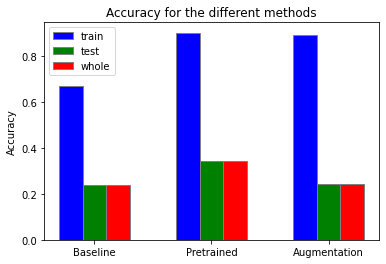

In [19]:
train_accuracies = [0.6700, 0.9000, 0.8900]
test_accuracies = [acc_test_quest_3,acc_test_quest_4,acc_test_quest_6]
full_accuracies = [acc_whole_quest_3,acc_whole_quest_4,acc_whole_quest_6]

train_bars = [i for i in range(len(train_accuracies))]
test_bars = [x + 0.2 for x in train_bars]
whole_bars= [x + 0.4 for x in train_bars]

plt.bar(train_bars, train_accuracies, color ='b', width = 0.2, edgecolor ='grey', label ='train')
plt.bar(test_bars, test_accuracies, color ='g', width = 0.2, edgecolor ='grey', label ='test')
plt.bar(whole_bars, test_accuracies, color ='r', width = 0.2, edgecolor ='grey', label ='whole')

plt.xticks([i+0.2 for i in range(len(train_accuracies))],
        ["Baseline", "Pretrained", "Augmentation"])

plt.ylabel("Accuracy")
plt.title("Accuracy for the different methods")
plt.legend()
plt.show()

# Weak supervision

__Bonus \[open\] question (up to 3 points) :__ Pick a weakly supervised method that will potentially use $X\cup X_{\text{train}}$ to train a representation (a subset of $X$ is also fine). Evaluate it and report the accuracies. You should be careful in the choice of your method, in order to avoid heavy computational effort.

As a weakly supervised method without heavy computational effort we propose label-propagation to use in $X \cup X_{\text{train}}$. This semi-supervised technique propagate labels to the unlabeled data. Then, we can use these new labels to train our ResNet18.

In [4]:
import numpy as np
from sklearn.semi_supervised import LabelPropagation

In [5]:
train_set = datasets.CIFAR10(root='./data', train=True,
                             download=True, transform=train_transform)
train_100 = torch.utils.data.Subset(train_set, np.arange(n_samples))

test_set = datasets.CIFAR10(root='./data', train=False,
                             download=True, transform=test_transform)

full_set = torch.utils.data.ConcatDataset([train_set, test_set])
train_unlab = torch.utils.data.Subset(train_set, np.arange(100, len(train_set)))

Files already downloaded and verified
Files already downloaded and verified


In [6]:
train_labeled_features = []
train_labeled_labels = []
for i in np.arange(100):
    train_labeled_features.append(train_set[i][0].numpy().flatten())
    train_labeled_labels.append(train_set[i][1])
train_labeled_labels = np.reshape(train_labeled_labels, (-1, 1))

label_prop_model = LabelPropagation(kernel='knn', n_neighbors=5)
label_prop_model.fit(train_labeled_features, train_labeled_labels)

train_unlab_features = []
for i in np.arange(100, len(train_set)):
    train_unlab_features.append(train_set[i][0].numpy().flatten())
train_unlab_labels = label_prop_model.predict(train_unlab_features)

train_unlab_labels = train_unlab_labels.reshape(len(train_unlab_labels), 1)
train_labels = np.concatenate((train_labeled_labels, train_unlab_labels))
train_features = train_labeled_features + train_unlab_features

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [7]:
train_data = list(zip(train_features, train_labels))
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)

In [11]:
batch_size = 10
learning_rate = 0.001
max_epoch = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


train_loader = torch.utils.data.DataLoader(train_100, batch_size=batch_size,
                                           shuffle=True, num_workers=2)
model = ResNet18()
loss_fcn = F.cross_entropy
score_fcn = Accuracy(task='multiclass', num_classes=10)
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
model = model.to(device)


_, _ = train(model, loss_fcn, score_fcn, device, optimizer, max_epoch, train_loader)

Epoch 00001 | Loss: 3.1831 | Accuracy: 0.0900
Epoch 00002 | Loss: 2.4273 | Accuracy: 0.1700
Epoch 00003 | Loss: 2.0323 | Accuracy: 0.2900
Epoch 00004 | Loss: 1.8549 | Accuracy: 0.3900
Epoch 00005 | Loss: 1.7824 | Accuracy: 0.3600
Epoch 00006 | Loss: 1.6809 | Accuracy: 0.4400
Epoch 00007 | Loss: 1.5765 | Accuracy: 0.4500
Epoch 00008 | Loss: 1.4603 | Accuracy: 0.4400
Epoch 00009 | Loss: 1.4127 | Accuracy: 0.5100
Epoch 00010 | Loss: 1.2424 | Accuracy: 0.5800
Epoch 00011 | Loss: 1.2696 | Accuracy: 0.5500
Epoch 00012 | Loss: 1.1298 | Accuracy: 0.6700
Epoch 00013 | Loss: 1.0438 | Accuracy: 0.6000
Epoch 00014 | Loss: 0.8461 | Accuracy: 0.7000
Epoch 00015 | Loss: 0.7882 | Accuracy: 0.7200
Epoch 00016 | Loss: 0.6225 | Accuracy: 0.8200
Epoch 00017 | Loss: 0.6400 | Accuracy: 0.8200
Epoch 00018 | Loss: 0.5869 | Accuracy: 0.8300
Epoch 00019 | Loss: 0.6330 | Accuracy: 0.8300
Epoch 00020 | Loss: 0.5181 | Accuracy: 0.7900


In [14]:
test_loader = torch.utils.data.DataLoader(test_set, 
                                          batch_size=batch_size, 
                                          num_workers=2)
full_loader = torch.utils.data.DataLoader(full_set, batch_size=batch_size, shuffle=True)

print('Evaluation on test dataset:',evaluate(model, loss_fcn, score_fcn, device, test_loader))
print('Evaluation on whole dataset:',evaluate(model, loss_fcn, score_fcn, device, full_loader))

Evaluation on test dataset: 0.2505
Evaluation on whole dataset: 0.24745


| Model | Number of  epochs  | Train accuracy | Test accuracy | Whole dataset accuracy	
|------|------|------|------|---|
|   LabelPropagation+ResNet18  | 20 | 0.7900 | 0.2505 | 0.24745|